# Predicting Housing Prices

These are some of the packages that we will be working with. So I like to import them before we get to the exploratory and model fitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import featuretools as ft
import utils
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.preprocessing import scale, robust_scale, RobustScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

Lets load in the data

In [6]:
train_houses = "/Users/Alberto/Desktop/Housing Regression/all/train.csv"
test_houses = "/Users/Alberto/Desktop/Housing Regression/all/test.csv"
sample_houses = "/Users/Alberto/Desktop/Housing Regression/all/sample_submission.csv"

train = pd.read_csv(train_houses)
test = pd.read_csv(test_houses)
sample = pd.read_csv(sample_houses)
house_prices = train['SalePrice'].copy()

Lets fix the missing values that are in our data. First, lets work on fixing the missing values in the training.

In [7]:
train_na = (train.isnull().sum()/len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending = False)[:30]
missing_data_train = pd.DataFrame({'Missing Ratio': train_na})
missing_data_train = missing_data_train['Missing Ratio'].astype('float')

Lets look at the distribution of NA across all of our features.

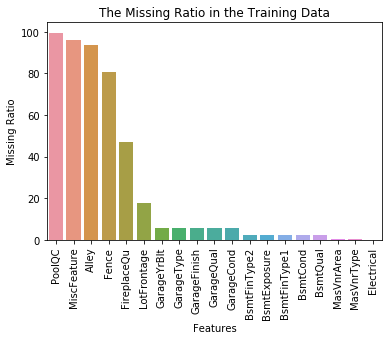

In [9]:
plt.xticks(rotation = 90)
sns.barplot(x = missing_data_train.index, y = missing_data_train)
plt.xlabel("Features")
plt.ylabel("Missing Ratio")
plt.title("The Missing Ratio in the Training Data")
plt.show()

Lets fill in the missing values in our data.

In [10]:
#PoolQC
train["PoolQC"] = train["PoolQC"].fillna("None")
#MiscFeature
train["MiscFeature"] = train["MiscFeature"].fillna("None")
#Alley
train["Alley"] = train["Alley"].fillna("None")

#FEnce
train["Fence"] = train["Fence"].fillna("None")
#FireplaceQu
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
#LotFrontage
med = train["LotFrontage"].median()
train["LotFrontage"] = train["LotFrontage"].fillna(med)
# GarageType, GarageFinish, GarageQual, GarageCond
for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    train[col] = train[col].fillna("None")
#GarageYrBlt
train["GarageYrBlt"] = train["GarageYrBlt"].fillna(0)
#BsmtFinType1, BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond
for col in ("BsmtFinType1", "BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond"):
    train[col] = train[col].fillna(0)
#MasVnrArea
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
#MasVnrType
train["MasVnrType"] = train["MasVnrType"].fillna("None")
#Electrical
train["Electrical"] = train["Electrical"].fillna(train["Electrical"].mode()[0])

Lets see if our data has any outliers present.

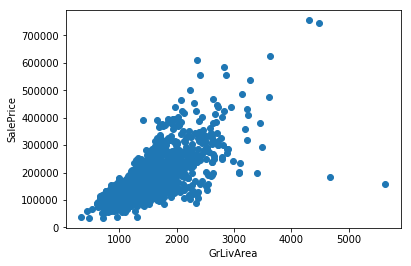

In [11]:
plt.scatter(x = train['GrLivArea'], y = train["SalePrice"])
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")
plt.show()

We see tgat we do have some outliers in our data. GrLivArea > 4000 and Price < 300,000

In [12]:
out = train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)]
train = train.drop([523, 1298])

Lets see if we can find any other relationships or outliers we can remove from numeric features.

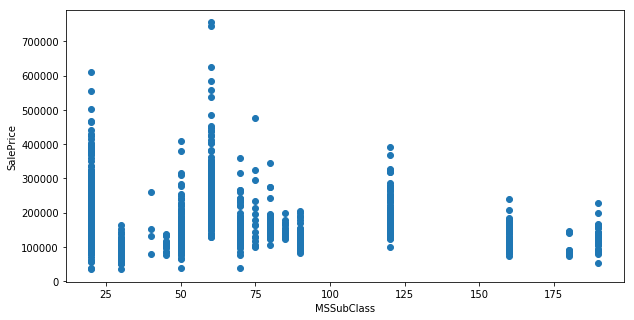

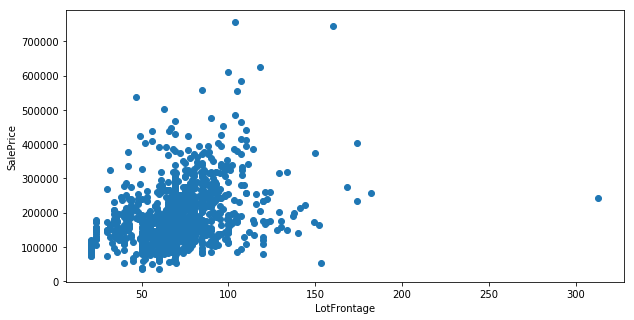

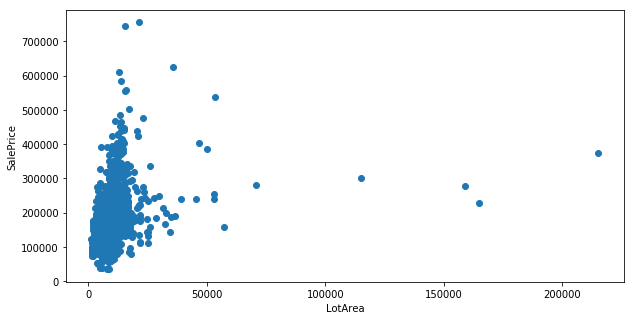

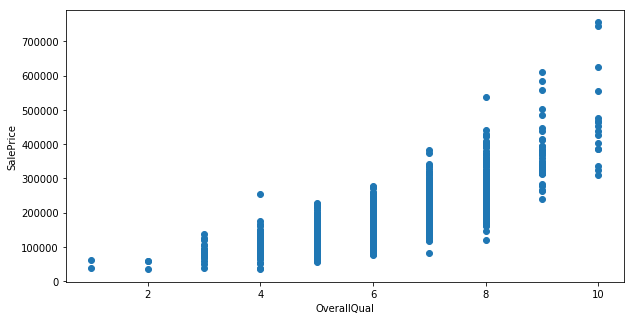

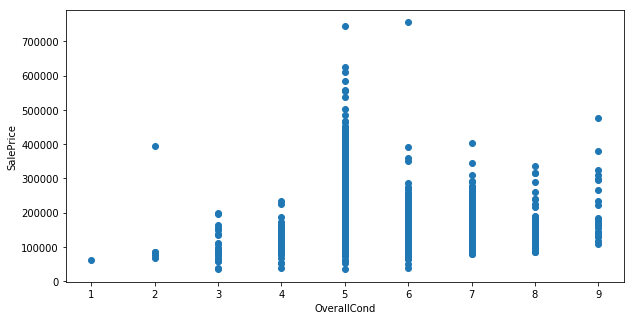

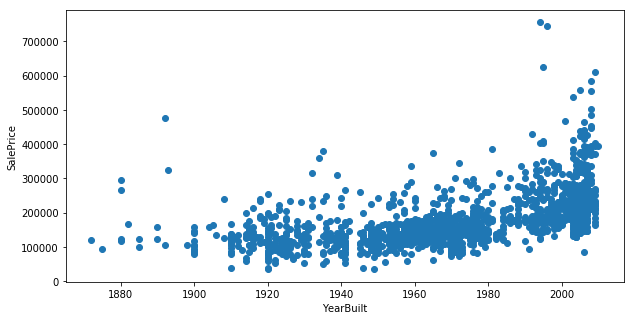

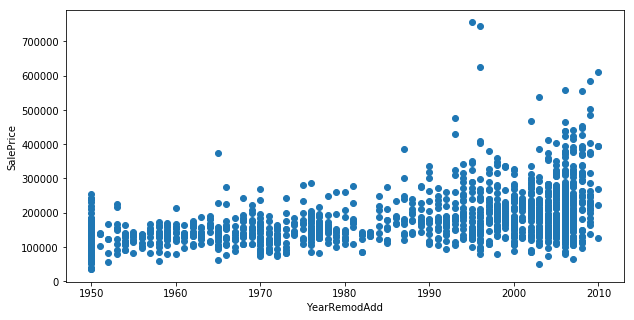

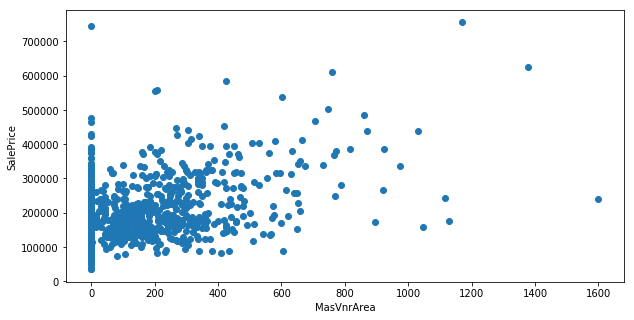

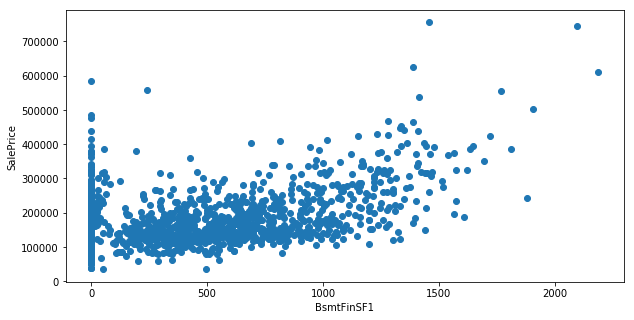

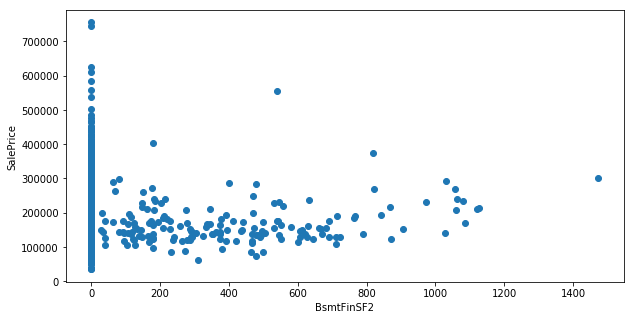

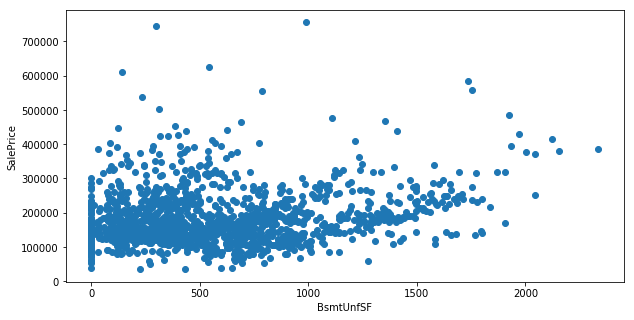

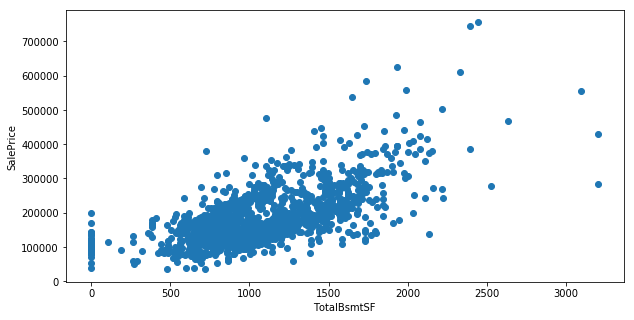

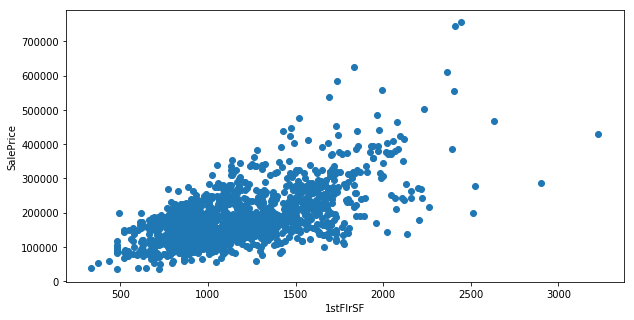

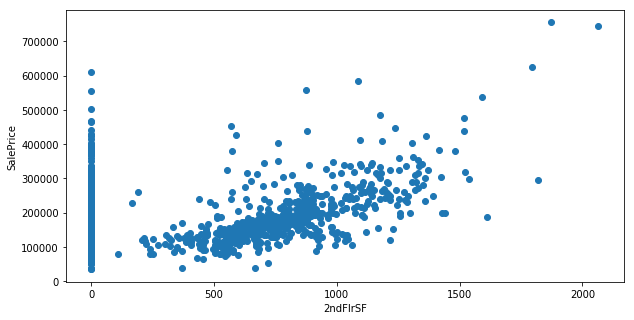

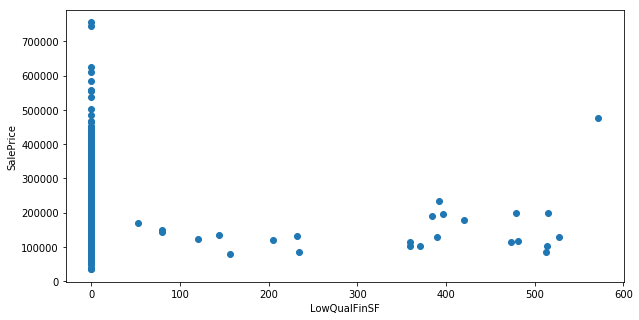

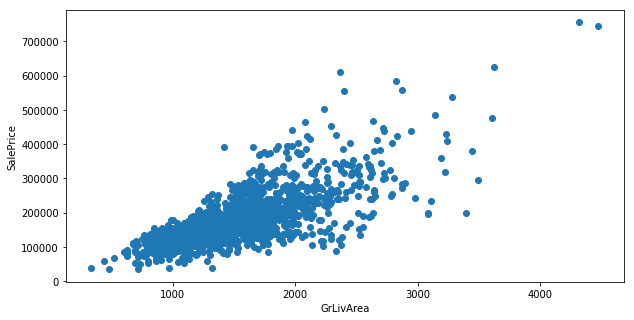

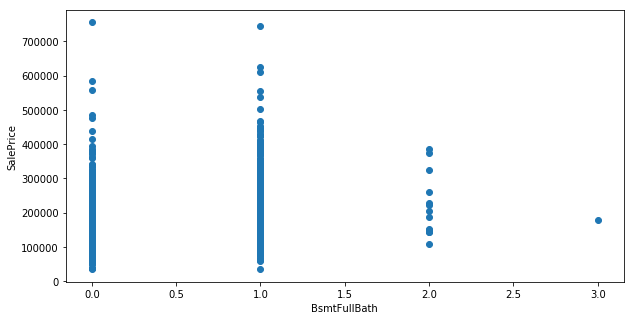

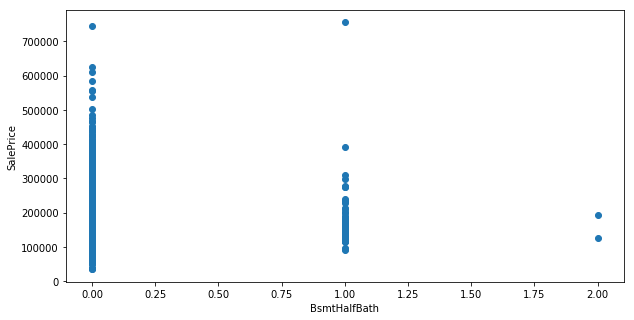

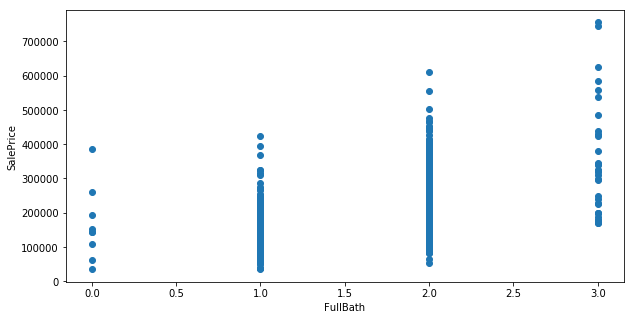

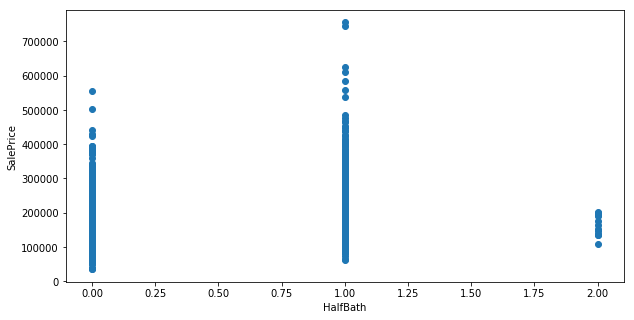

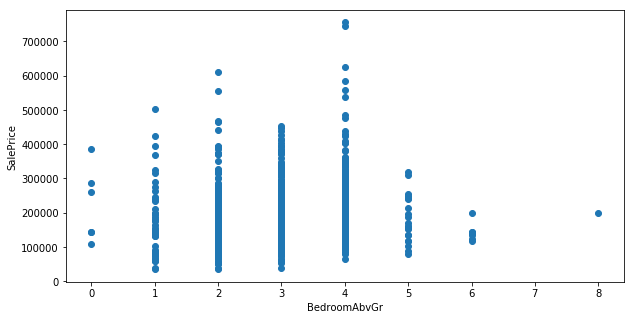

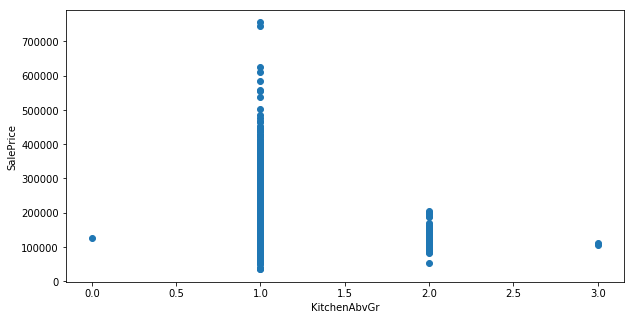

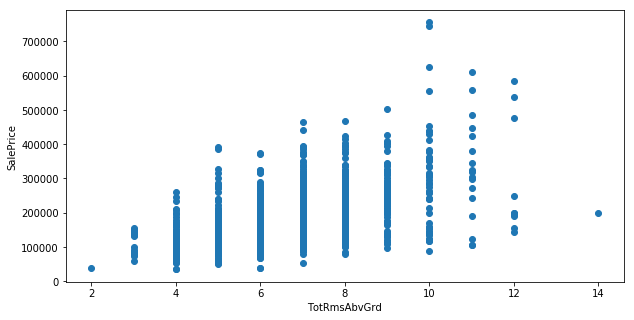

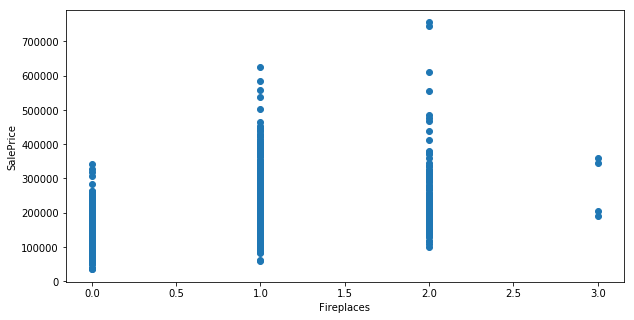

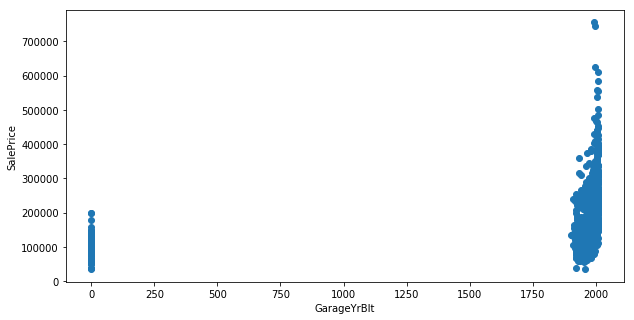

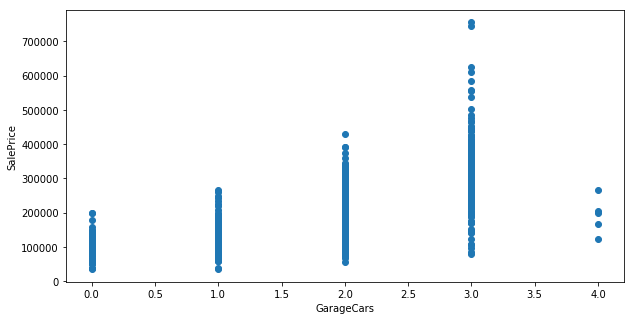

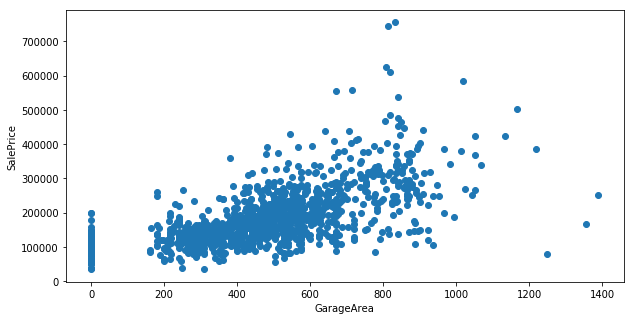

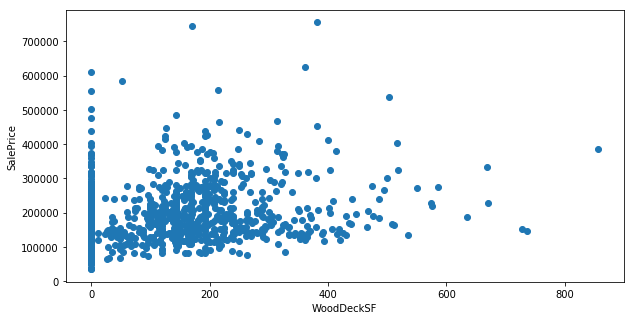

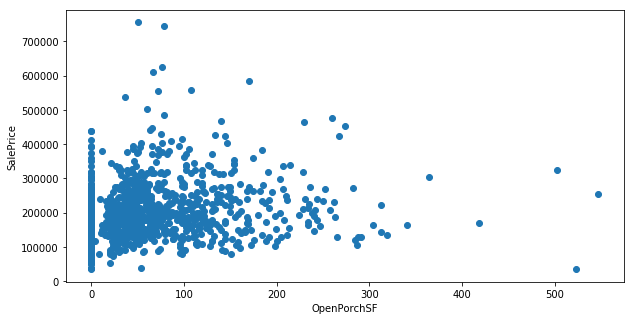

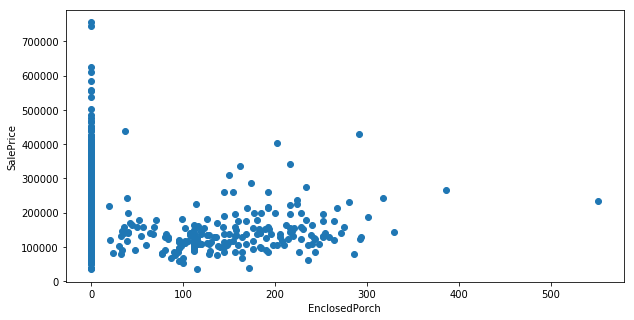

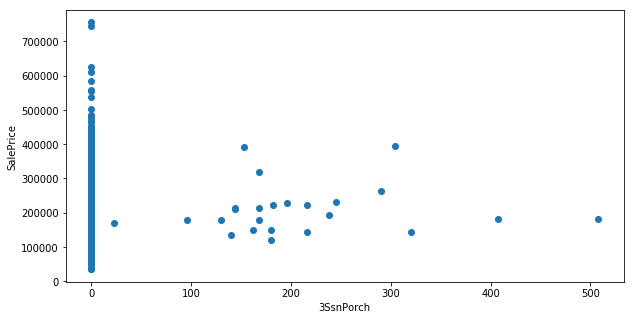

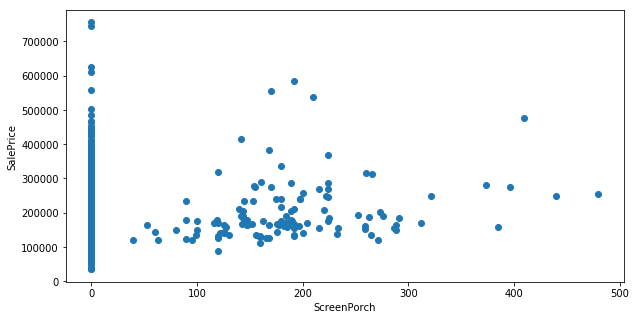

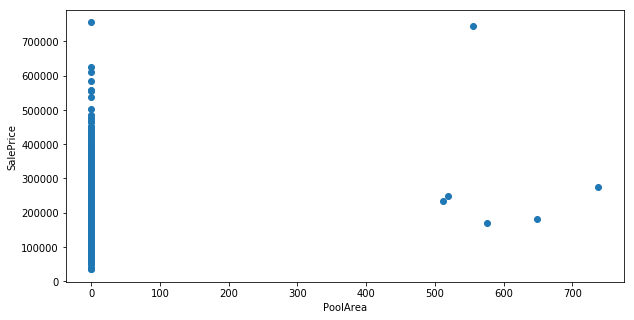

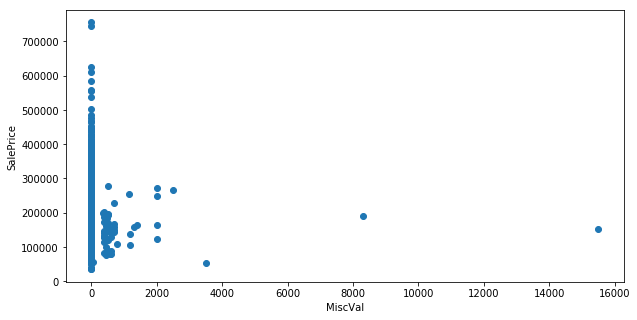

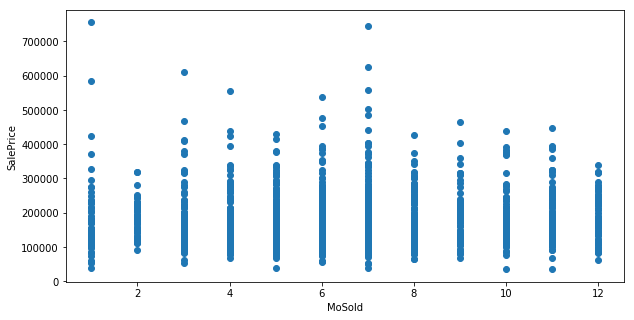

In [27]:
numeric_features = train.dtypes[train.dtypes != "object"].index
numeric_features = numeric_features.drop("Id")
numeric_data = list(numeric_features)

#Lets visualize this data
for i,c in zip(range(1,36), numeric_data):
    plt.figure(1, figsize= (100,50))
    plt.subplot(6,6,i)
    plt.scatter(train[c], train["SalePrice"])
    plt.xlabel(c)
    plt.ylabel("SalePrice")
    plt.subplots_adjust(hspace = .8, wspace = .8)
    plt.show()


Looking at the above graphs we can get an idea of which ones we can to work with to elimate outliers from. Lets take a deeper look at specific ones.

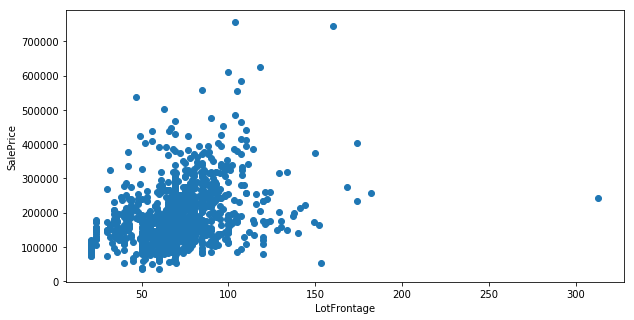

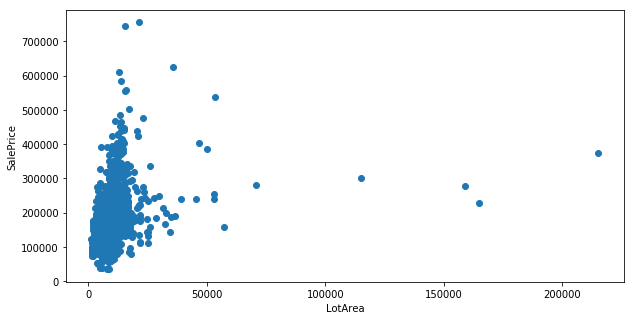

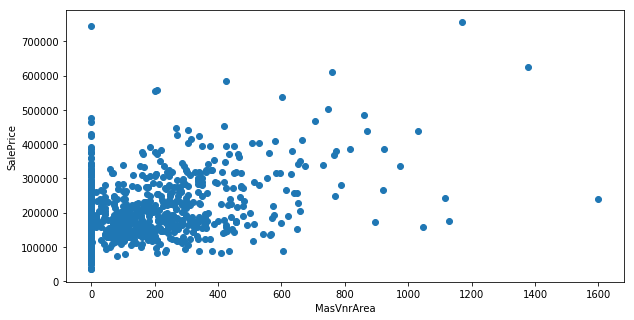

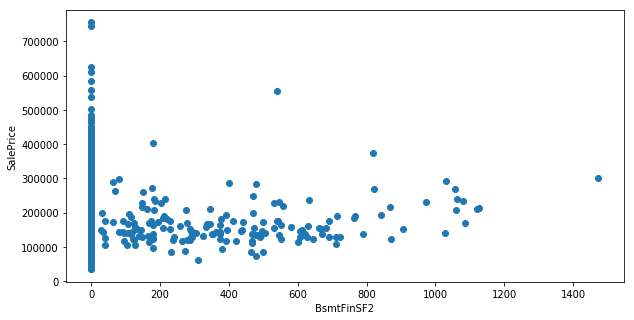

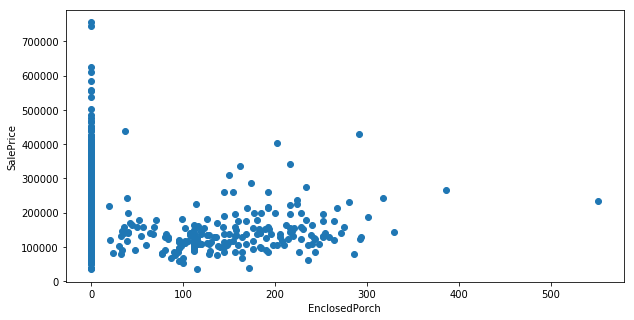

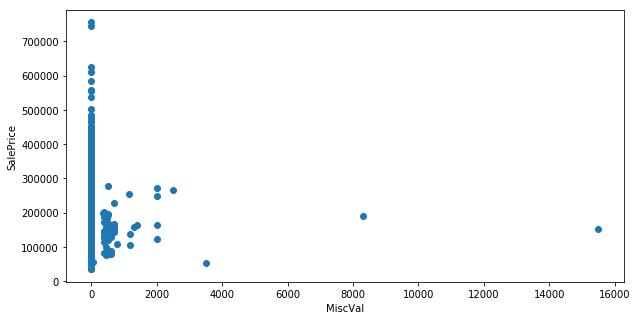

In [30]:
#These are some that I found to be outlier cases

def graph_scatter(df, col):
    plt.figure(1, figsize= (10,5))
    plt.scatter(df[col], train["SalePrice"])
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.show()
 

graph_scatter(train, numeric_data[1])
graph_scatter(train, numeric_data[2]) #No drop yet
graph_scatter(train, numeric_data[7]) #ok
graph_scatter(train, numeric_data[9]) # ddrop >1400
graph_scatter(train, numeric_data[29]) # drop > 500
graph_scatter(train, numeric_data[33]) # drop > 8000



Deleting more outliers

In [31]:
#Deleting more outliers 
lotfrontage = train[train["LotFrontage"] > 300] #934
BsmtFinSF2 = train[train["BsmtFinSF2"] > 1400] #322
EnclosedPorch = train[train["EnclosedPorch"] > 500] #197
MiscVal = train[train["MiscVal"] > 8000] #346,1230
train = train.drop([197, 322, 346, 934, 1230])
